# Notebook for Calibrating Time Tool

# Import Necessary Packages

In [52]:
import numpy as np
import pandas as pd
import h5py

import psana

import matplotlib
import matplotlib.pyplot as plt
#%matplotlib widget

from scipy.ndimage import gaussian_filter as gf
from scipy.ndimage import gaussian_filter1d as gf1
from scipy.signal import find_peaks
from scipy.stats import pearsonr as pr
from scipy.optimize import curve_fit
import scipy.optimize as opt 
import scipy.special
from scipy.interpolate import InterpolatedUnivariateSpline
from scipy.interpolate import interp1d
from scipy.io import loadmat
from scipy.optimize import minimize
from xray_functions import *

import math
import time
import os

#import this

# List of Keywords to Read From .h5 file

Given the massive amounts of data collected for a single CXI time resolved run, the data is processed prior to our analysis and the results of each run are stored as a .h5 file which are similar to .mat files and can store a multitude of information of various types.

To access the variables stored within a .h5 file, we will be using the h5py library. The following lists are variable paths and keys within the .h5 file which will be imported when reading the run data. These keys will often need editing, or commenting in and out depending on the information being collected for each run.

In [53]:
keys_to_combine = ['tt/FLTPOS',
                   'tt/AMPL',
                   'tt/FLTPOSFWHM',
                   'tt/ttCorr',
                   # 'ttRaw/tt_reference',
                   'ttRaw/tt_signal',
                   #'ttRaw/pos',
                    'ttRefit_LFH/ampl',
                    'ttRefit_LFH/edge_locations',
                    'ttRefit_LFH/normalized_data',
                    'ttRefit_LFH/slope',
                   'ttRefit_IG/height',
                   'ttRefit_IG/width',
                   'ttRefit_IG/edge_locations',
                   # 'alvium_u1/laser_sum',
                   # 'Acqiris/Laser_area',
                   # 'Acqiris/FastTiming_area',
                   # 'alvium_u1/laser_com',
                   #'epics/lxt',
                   'scan/var0',
                   #'scan/varStep',
                   #'scan/LAS:FS5:VIT:FS_TGT_TIME_DIAL',
                   'ipm_dg2/sum',
                   #'ipm_dg3/sum',
                   'gas_detector/f_11_ENRC',
                   'gas_detector/f_22_ENRC',
                   # 'jungfrau4M/azav_azav',
                   'evr/code_183',
                   'evr/code_137',
                   'lightStatus/laser',
                   'lightStatus/xray',
                   'ebeam/pk_curr_bc2',
                   # 'qadc0/full_area', 
                   # 'qadc1/full_area'
                   #'ttRawRefit/edge_locations',
                  ]
keys_to_sum = []
keys_to_check = [#'UserDataCfg/jungfrau4M/azav__azav_q',
                 #'Sums/jungfrau4M_calib_xrayOn',
                # 'UserDataCfg/jungfrau4M/azav__azav_qbin',
                # 'UserDataCfg/jungfrau4M/azav__azav_qbins',
                # 'UserDataCfg/jungfrau4M/x',
                # 'UserDataCfg/jungfrau4M/y',
                # 'UserDataCfg/jungfrau4M/z',
                # # 'UserDataCfg/jungfrau4M/azav__azav_matrix_q',
                # # 'UserDataCfg/jungfrau4M/azav__azav_matrix_phi',
                # 'UserDataCfg/jungfrau4M/azav__azav_idxq',
                # 'UserDataCfg/jungfrau4M/cmask',
                # 'UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU',
                # 'UserDataCfg/jungfrau4M/Full_thres__Full_thres_bound',
                # 'UserDataCfg/jungfrau4M/common_mode_pars',
                ]
all_keys = keys_to_combine+keys_to_sum+keys_to_check

## Functions for reading in .h5 files

In [54]:
def get_tree(f):
    """List the full tree of the h5 file. Not currently used in Radial Analyzer code."""
    def printname(name):  # needed because .visit needs callable
        print(name, type(f[name]))
    f.visit(printname)
    
def is_leaf(dataset):
    return isinstance(dataset,h5py.Dataset)

def get_leaves(f,saveto,verbose=True,keys=None):
    """Way of organizing the data I think? Used to put together combined data in the CombineRuns function"""
    def return_leaf(name):
        if is_leaf(f[name]):
            if verbose:
                print(name,f[name][()].shape)
            if keys is None or name in keys:
                saveto[name] = f[name][()]
    f.visit(return_leaf)

def group_var_by_stage(var_array, stage_array):
    """Function which returns variables which have been grouped by their stage position. Currently this is done through indexing which might be the best
    approach"""
    unique_pos = np.unique(stage_array)
    grouped_vars = []
    for i in range(len(unique_pos)):
        groups = var_array[np.where(scan == unique_pos[i])[0]]
        #print(len(groups))
        grouped_vars.append(groups)
    return unique_pos, grouped_vars

def runNumToString(num):
    """Effective way of converting run number to a string of length 4"""
    numstr = str(num)
    while len(numstr)<4:
        numstr = '0'+numstr
    return numstr

def combineRuns(runNumbers,folder,experiment, verbose=True,keys=all_keys):
    """Key function for reading in the h5 files returned by the preprocessing pipeline. The function requires a list of run number, the path do the folder, and an 
    experiment identifier string. Additionally, the function can also take in keys and a call to print via verbose=True. Default is true.
    If certain keywords are listed which are not found in the h5 file, an error will be raised."""
    data_array = []
    experiment = folder.split('/')[6]
    for i,runNumber in enumerate(runNumbers):
        data = {}
        try:
            filename = f'{folder}{experiment}_Run{runNumToString(runNumber)}.h5'
        except Exception:
            print("Problem with filename or directory in combineRuns")
        
        print(filename)
        with h5py.File(filename,'r') as f:
            get_leaves(f,data,verbose=verbose,keys=all_keys)
            if 'jungfrau4M/azav_azav' in all_keys:
                azav_run = data['jungfrau4M/azav_azav']
                if len(azav_run.shape)==3:
                    azav_run = np.nanmean(azav_run,axis=1)
                    data['jungfrau4M/azav_azav'] = azav_run
            data_array.append(data)
    print('loaded data')
    data_combined = {}
    for key in keys_to_combine:
        arr = np.squeeze(data_array[0][key])
        for data in data_array[1:]:
            arr = np.concatenate((arr,np.squeeze(data[key])),axis=0)
        data_combined[key] = arr
    run_indicator = np.array([])
    for i,runNumber in enumerate(runNumbers):
        run_indicator = np.concatenate((run_indicator,runNumber*np.ones_like(data_array[i]['tt/FLTPOS'])))
    data_combined['run_indicator'] = run_indicator
    for key in keys_to_sum:
        arr = np.zeros_like(data_array[0][key])
        for data in data_array:
            arr += data[key]
        data_combined[key] = arr
    for key in keys_to_check:
        arr = data_array[0][key]
        for i,data in enumerate(data_array):
            if not np.array_equal(data[key],arr):
                print(f'Problem with key {key} in run {runNumbers[i]}')
                print(arr,data[key])
        data_combined[key] = arr
    return data_combined

## Plotting Functions

In [55]:
param_dict = {'spinewidth':2,
              'linewidth':4,
              'ticklength':6,
              'tickwidth':3,
              'ticklabelsize':20,
              'axislabelsize':20,
              'titlesize':25}

def neaten_plot(neatenme, param_dict=param_dict):
    """Function for producing neat plot with set fontsize, dimensions, etc.
    Inputs include a call to plot such as plt.gcf() and a dictionary of parameters as defined above."""
    if isinstance(neatenme,matplotlib.figure.Figure):
        for ax in neatenme.axes:
            neaten_plot(ax)
        plt.tight_layout()
    elif isinstance(neatenme,matplotlib.axes.Axes):
        neatenme.tick_params(labelsize=param_dict['ticklabelsize'],length=param_dict['ticklength'],
                             width=param_dict['tickwidth'])
        neatenme.xaxis.get_label().set_fontsize(param_dict['axislabelsize'])
        neatenme.yaxis.get_label().set_fontsize(param_dict['axislabelsize'])
        neatenme.title.set_fontsize(param_dict['titlesize'])
        for axis in ['top','bottom','left','right']:
            neatenme.spines[axis].set_linewidth(param_dict['spinewidth'])
        for line in neatenme.lines:
            line.set_linewidth(param_dict['linewidth'])
            
def plot_jungfrau(x,y,z,ax=None,shading='nearest',*args,**kwargs):
    """Plots images from the jungfrau camera. Never called in the Radial Analyzer code. Inputs are x,y,z values read from the 
    camera named Jungfrau """
    if not ax:
        ax=plt.gca()
    for i in range(8):
        pcm = ax.pcolormesh(x[i],y[i],z[i],shading=shading,*args,**kwargs)
    return pcm

# Define Experiment Parameters 

Set up path to data and define any other experiment specific parameters

In [56]:
#runNumbers = [224, 225, 226, 227, 228, 230, 231, 232]  # enter the run numbers to be loaded
runNumbers = [70]

experiment = 'cxi100895124' #make sure to update this field with the correct experiment number
folder = f'/sdf/data/lcls/ds/cxi/{experiment}/hdf5/smalldata/'

#UV_energies = [7.36479, 5.919081, 4.869608, 4.142788, 3.417873, 2.397069, 1.792513, 0.365581] # required for power scans

filename = f"{folder}{experiment}_Run{runNumToString(runNumbers[0])}.h5"
with h5py.File(filename,'r') as f:
    print(f.keys())
    print(f['ttRaw/'].keys())
    print(f['ebeam/'].keys())


<KeysViewHDF5 ['CXI-DG2-BMMON-WF', 'Sums', 'UserDataCfg', 'damage', 'ebeam', 'epics', 'epicsOnce', 'event_time', 'evr', 'fiducials', 'gas_detector', 'ipm_dg2', 'ipm_hfx_dg2', 'ipm_hx2', 'jungfrau4M', 'lightStatus', 'proc_event_time', 'qadc0', 'qadc1', 'scan', 'tt', 'ttRaw', 'ttRefit_IG', 'ttRefit_LFH']>
<KeysViewHDF5 ['tt_reference', 'tt_reference_pj', 'tt_sideband', 'tt_sideband_pj', 'tt_signal', 'tt_signal_pj']>
<KeysViewHDF5 ['L3_energy', 'LTU_250', 'LTU_450', 'LTU_ang_x', 'LTU_ang_y', 'LTU_pos_x', 'LTU_pos_y', 'XTCAV_ampl', 'XTCAV_phase', 'charge', 'dump_charge', 'photon_energy', 'pk_curr_bc2', 'und_ang_x', 'und_ang_y', 'und_pos_x', 'und_pos_y']>


# Read h5 Files and Set-Up Variables

This cell sets up all the variables by parsing the h5 file. Depending on the run, different h5 files contain different variables so this has to be adjusted frequently. You can choose to load just one run or many runs by using lists of run numbers. __NOTE:__ This takes time so be patient...

In [57]:
data = combineRuns(runNumbers,folder, experiment, verbose=False)
runNumbersRange = '[%d - %d]' % (min(runNumbers),max(runNumbers))


ttpos_old = data['tt/FLTPOS'] #Corresponds to the edge position in pixels
ttpos = data['ttRefit_LFH/edge_locations'] 
ttRefit_amp= data['ttRefit_LFH/ampl']
ttRefit_edges = data['ttRefit_LFH/edge_locations']
ttRefit_data = data['ttRefit_LFH/normalized_data']
ttRefit_slopes = data['ttRefit_LFH/slope']
ttampl_IG = data['ttRefit_IG/height']
xray_duration_rough = data['ebeam/pk_curr_bc2']

# ttpos = data['ttRefit_IG/edge_locations']
# ttampl = data['ttRefit_IG/height']
# ttRefit_amp= data['ttRefit_IG/height']
# ttRefit_edges = data['ttRefit_IG/edge_locations']
# # ttRefit_data = data['ttRefit_IG/normalized_data']
# ttRefit_slopes = data['ttRefit_IG/width']

# qadc0 = data['qadc0/full_area']
# qadc1 = data['qadc1/full_area']

ttfwhm = data['tt/FLTPOSFWHM']
ttampl = data['tt/AMPL']
ttRaw = data['ttRaw/tt_signal']
#scan = data['epics/lxt']

# UV_sum = data['alvium_u1/laser_sum']
# UV_com = data['alvium_u1/laser_com']
# idxq = data['UserDataCfg/jungfrau4M/azav__azav_idxq'].reshape(8,512,1024)
# qbin_size = np.bincount(idxq[idxq>0].flatten())
#scan = data['scan/LAS:FS5:VIT:FS_TGT_TIME_DIAL']
#scan = data['scan/varStep']
scan=data['scan/var0']
# q = data['UserDataCfg/jungfrau4M/azav__azav_q']
# qbin = data['UserDataCfg/jungfrau4M/azav__azav_qbin']
# qbins = data['UserDataCfg/jungfrau4M/azav__azav_qbins']
# Acqiris_FastTiming = data['Acqiris/FastTiming_area']
# Acqiris_Laser = data['Acqiris/Laser_area']
# x = data['UserDataCfg/jungfrau4M/x']
# y = data['UserDataCfg/jungfrau4M/y']
# z = data['UserDataCfg/jungfrau4M/z']
# #matrix_q = data['UserDataCfg/jungfrau4M/azav__azav_matrix_q'].reshape(8,512,1024)
#matrix_phi = data['UserDataCfg/jungfrau4M/azav__azav_matrix_phi'].reshape(8,512,1024)
dg2 = data['ipm_dg2/sum']
#dg3 = data['ipm_dg3/sum']
xray_energy = data['gas_detector/f_22_ENRC']
# azav = np.squeeze(data['jungfrau4M/azav_azav'])
# azav_xrays = azav*qbin_size
laserOn = data['evr/code_183'].astype(bool)
xrayOn = data['evr/code_137'].astype(bool)
laserOn2 = data['lightStatus/laser'].astype(bool)
xrayOn2 = data['lightStatus/xray'].astype(bool)
#on_sum = data['Sums/jungfrau4M_calib_xrayOn']
# dropped_sum = data['Sums/jungfrau4M_calib_dropped']
#jungfrau_sum = data['Sums/jungfrau4M_calib']
# jungfrau_sum = data['Sums/jungfrau4M_calib_thresADU1']
run_indicator = data['run_indicator']
#cmask = data['UserDataCfg/jungfrau4M/cmask'].astype(bool)
tt_Corr = data['tt/ttCorr']
# tt_reference = data['ttRaw/tt_reference']
# tt_signal = data['ttRaw/tt_signal']
#tt_reference = (tt_reference.T/np.sum(tt_reference[:,600:],axis=1)).T
#tt_signal = (tt_signal.T/np.sum(tt_signal[:,600:],axis=1)).T
#cmask = data['UserDataCfg/jungfrau4M/cmask'].astype(bool)
#detector_efficiency = np.load('detector_efficiency_15p3KeV.npy')
#detector_efficiency = np.interp(q,detector_efficiency[0],detector_efficiency[1])
#azav_corr = azav_xrays/detector_efficiency
#q = q[1:-1]
#azav_xrays = azav_corr[:,1:-1]
#qbin_size = qbin_size[1:-1]
#cmask1 = np.load('/sdf/home/n/nag1647/Fast_Analysis/Masks/line_mask.npy') #For testing the notebook
#cmask1 = np.ones((8,512,1024))
# cmask2 = np.ones((8,512,1024)) #For testing the notebook
#cmask2 = np.load('/sdf/data/lcls/ds/cxi/cxil1006021/scratch/nag1647/Masks/Mask_Jungfrau_19_29.npy')
#cmask3 = np.load('/sdf/data/lcls/ds/cxi/cxil1006021/scratch/nag1647/Masks/Mask_Jungfrau_29.npy')
#cmask_tot = cmask #Can multiply to combine different masks here
#threshold = data['UserDataCfg/jungfrau4M/Full_thres__Full_thres_thresADU']
#cmpars = data['UserDataCfg/jungfrau4M/common_mode_pars']
index = np.arange(0,laserOn.size)
print("Done!")

/sdf/data/lcls/ds/cxi/cxil1035023/hdf5/smalldata/cxil1035023_Run0095.h5
loaded data
Done!


# Timetool Analysis

The timetool is the instrument that gives you the time delay between the laser and X-rays on a shot-by-shot basis. In this instrument, the X-rays are overlapped with a broad chirped laser pulse and sent through a material that attenuates the laser. The arrival of the X-rays abruptly increases the absorption of the attenuator, and thus the back end of the laser pulse is attenuated more. Since the pulse is chirped, that means there will be an edge in the spectrum of the transmitted chirped pulse that can be measured in a spectrometer. The edge position in the spectrum is directly related to the arrival time of the X-rays relative to the laser pulse. 

The online analysis of the timetool performs a fit for the edge location, width, and amplitude. These are all written out as point data, and we use these extensively to both diagnose problems during beamtime and get sufficient time resolution in our post-analysis. Let's look a these timetool values.

### Check Initial Fitting

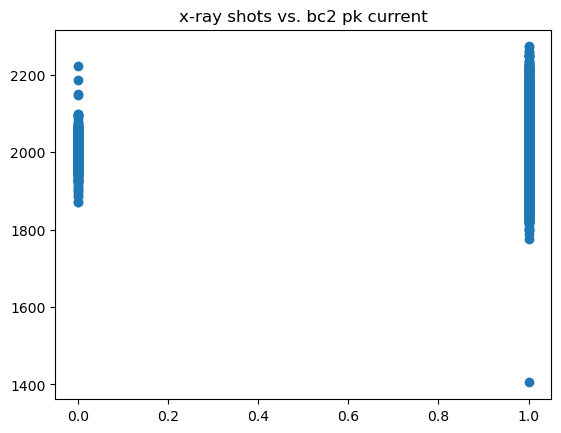

In [58]:
plt.figure()
plt.scatter(xrayOn,xray_duration_rough) #plot peak current of bc2 vs xray on shots.
plt.title('x-ray shots vs. bc2 pk current')
plt.show()

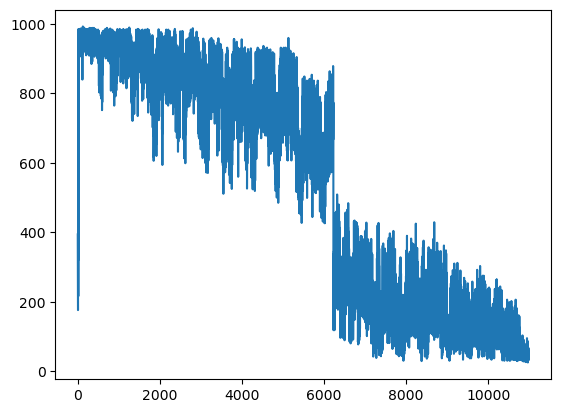

Fraction of good data based on tt is 0.30358228757808614


In [59]:
plt.figure()
plt.plot(ttRefit_edges[np.where(ttRefit_edges>0)[0]]) #Plot where the values in the 1D ttRefit_edges array are greater than zero
plt.show()

print(f"Fraction of good data based on tt is {len(ttRefit_edges[np.where(ttRefit_edges>0)[0]])/len(ttRefit_edges)}") #"Good" data is defined as the entries in the array greater than zero.
#The ratio printed is simply the ratio of how many "good" values there were in the entire array. 

In [60]:
ttpos = data['tt/FLTPOS'] # timetool edge position
ttampl = data['tt/AMPL']   # timetool amplitude
ttfwhm = data['tt/FLTPOSFWHM']  # timetool width (FWHM)
ttpos_LH = data['ttRefit_LFH/edge_locations'] # timetool edge position
ttampl_LH = data['ttRefit_LFH/ampl']   # timetool amplitude
ttfwhm_IG = data['ttRefit_IG/width']  # timetool width (FWHM)
ttpos_IG = data['ttRefit_IG/edge_locations'] # timetool edge position
ttampl_IG = data['ttRefit_IG/height']   # timetool amplitude
ttfwhm_LH = data['ttRefit_LFH/slope']  # timetool width (FWHM)

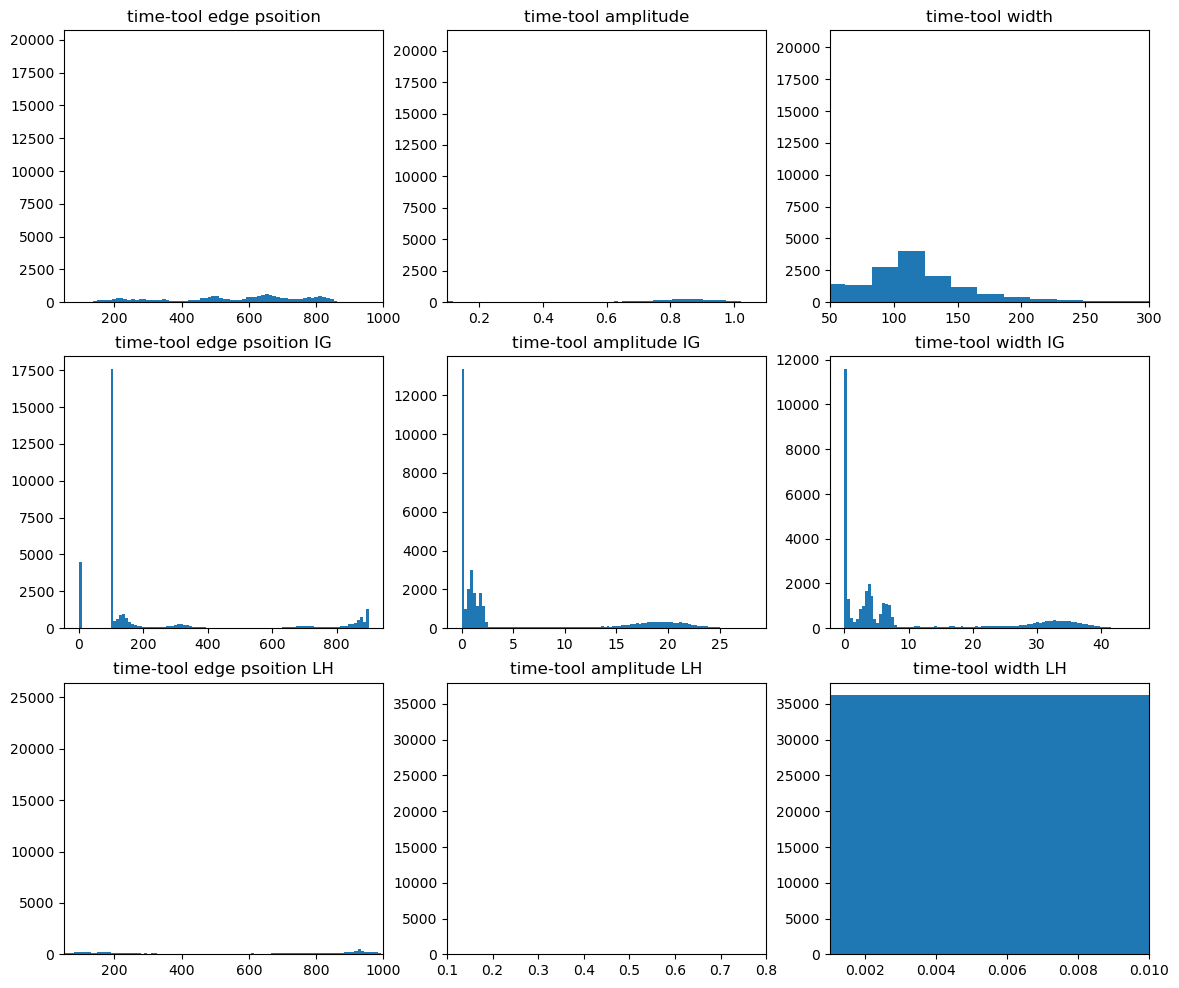

In [61]:
plt.figure(figsize=(14,12))

plt.subplot(3,3,1)
plt.hist(ttpos,bins=100)
plt.xlim(50,1000)
#plt.ylim(0,15000)
plt.title('time-tool edge psoition')

plt.subplot(3,3,2)
plt.hist(ttampl,bins=100)
plt.xlim(0.1, 1.1)
# plt.ylim(0, 5000)
plt.title('time-tool amplitude')

plt.subplot(3,3,3)
plt.hist(ttfwhm,bins=100)
plt.xlim(50, 300)
#plt.ylim(0,25000)
plt.title('time-tool width')

plt.subplot(3,3,4)
plt.hist(ttpos_IG,bins=100)
# plt.xlim(50,1000)
#plt.ylim(0,1500)
plt.title('time-tool edge psoition IG')

plt.subplot(3,3,5)
plt.hist(ttampl_IG,bins=100)
#plt.xlim(0.1, 1.1)
# plt.ylim(0,25000)
plt.title('time-tool amplitude IG')

plt.subplot(3,3,6)
plt.hist(ttfwhm_IG,bins=100)
# plt.xlim(50, 300)
#plt.ylim(0,2500)
plt.title('time-tool width IG')

plt.subplot(3,3,7)
plt.hist(ttpos_LH,bins=100)
plt.xlim(50,1000)
#plt.ylim(0,30000)
plt.title('time-tool edge psoition LH')

plt.subplot(3,3,8)
plt.hist(ttampl_LH,bins=100)
plt.xlim(0.1, 0.8)
#plt.ylim(0,100000)
plt.title('time-tool amplitude LH')

plt.subplot(3,3,9)
plt.hist(ttfwhm_LH,bins=100)
plt.xlim(0.001, 0.01)
#plt.ylim(0,25000)
plt.title('time-tool width LH')
#plt.xlim(0,0.01)
plt.show()

In [62]:
size = len(ttampl_IG)
print(size)
print(ttampl_IG)

36178
[0.         1.18860502 1.10911511 ... 0.99564923 0.95428537 0.79103449]


## Tracking Center Positions vs Time Position for TimeTool

### First: Use fast_erf_fit to determine centers  
Note: Built into this function is a low level filter which only returns fits in which the 10% index comes before the 90% index

In [63]:
#array = ttampl_IG #Input 1D array you want to analyze, if applicable
def fast_erf_fit(array, min_val = 0.2, max_val = 0.7):
    """Find position of line at 10% and at 90% and divide by two to approximate the center of the erf.
    Uses 1D data as array. Returns center positions, center amplitudes, and normalized data."""
    norm_temp = normalize(array) 
    length = len(array)
    try:
        min_pos = np.max(np.where(norm_temp < min_val)) #First, a boolean array is created where each element is marked True if the corresponding element in norm_temp is < min_val.
        #np.where returns an array with the indices as the True values. np.max extracts the maximum of index from the array of indices.
        max_pos = np.min(np.where(norm_temp > max_val)) #Analogous to previous line.
        range_val = max_pos - min_pos
        if (min_pos < max_pos):
            range_val = max_pos - min_pos
            cent_pos = int(((max_pos-min_pos)/2)+min_pos)
            cent_amp = norm_temp[cent_pos]
            norm_data = norm_temp
            slope_val = (norm_temp[max_pos] - norm_temp[min_pos])/(max_pos - min_pos)
        else: 
            range_val = 0
            cent_pos = 0
            cent_amp = 0
            norm_data = np.zeros(length)
            slope_val = 0
    except: 
        print("Exception occurred")
        return 0, 0, 0, 0
    
    return cent_pos, cent_amp, slope_val, norm_data

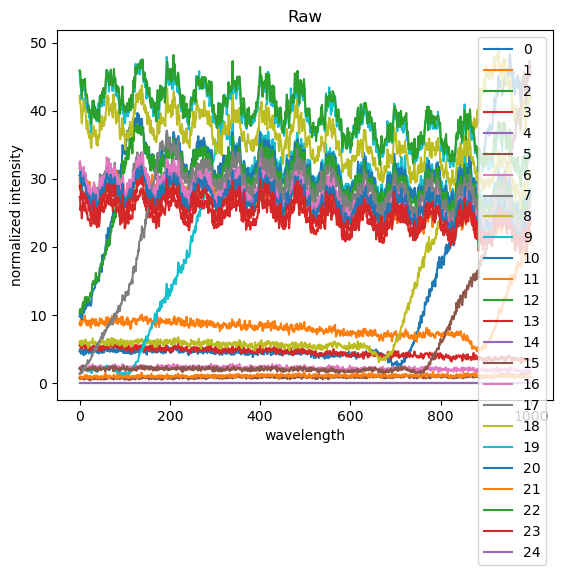

In [64]:
plt.figure()
i = 0
while i < 25:
    rand = np.random.randint(0,len(ttRaw))#A random index is chosen between zero and the length
    #of the ttraw array saved in the "rand" variable
    plt.plot(ttRaw[rand], label = i) #The element equal to "rand" is plotted, this is repeated 5 times. 
    #plt.plot(tt_reference[rand], "--")
    i = i + 1
plt.title("Raw")
plt.xlabel("wavelength")
plt.ylabel("normalized intensity")
plt.legend()
plt.show()

In [65]:
def fast_erf_fit2(array, min_val = 0.2, max_val = 0.6):
    """Find position of line at 25% and at 60% and divide by two to approximate the center of the erf.
    Uses 1D data as array. Returns center positions, center amplitudes, and normalized data."""
    norm_temp = normalize(array)
    length = len(array)
    try:
        min_pos = np.max(np.where(norm_temp < min_val))
        max_pos = np.min(np.where(norm_temp > max_val))
        range_val = max_pos - min_pos
        if (min_pos < max_pos):
            range_val = max_pos - min_pos
            cent_pos = int(((max_pos-min_pos)/2)+min_pos)
            cent_amp = norm_temp[cent_pos]
            norm_data = norm_temp
            slope_val = (norm_temp[max_pos] - norm_temp[min_pos])/(max_pos - min_pos)
        else: 
            range_val = 0
            cent_pos = 0
            cent_amp = 0
            norm_data = np.zeros(length)
            slope_val = 0
    except: 
        #print("exception occurred")
        return 0, 0, 0, np.zeros(length)

    return cent_pos, cent_amp, slope_val, norm_data

In [66]:
start = time.time()

centers = []
amps = []
norm_all = []
scan_good = []
slopes = []
min_val = 0.3
max_val= 0.7
for i in range(len(ttRaw)):
    #temp = savgol_filter(ttRaw[i], 251, 3)
    temp=ttRaw[i] #Represents one row of the ttRaw data array
    min_raw = np.min(temp) #min value in i row of ttRaw data array
    max_raw = np.max(temp) ##min value in i row of ttRaw data array
    if min_raw > 0.15* max_raw: #If the min value in the array is larger than 15% (or a chosen percentage) of the max value, the values for slope, centers and amps on are set to zero
        #and a zero array is added to the norm_all array
        slopes.append(0)
        centers.append(0)
        amps.append(0)
        norm_all.append(np.zeros(len(ttRaw[i])))
        continue
    cent_pos, cent_amp, slope_val, norm_data = fast_erf_fit2(temp, min_val=min_val, max_val=max_val)#Values that pass the initial filter above are run through the fast_erf_fit2 function in the block above.
    slopes.append(slope_val)#Starts entering values in the slope array, appending the next "i" rows data each loop. 
    centers.append(cent_pos)
    amps.append(cent_amp)
    #print(norm_data.shape)
    norm_all.append(np.array(norm_data))

#print(norm_all)
centers = np.array(centers)
amps = np.array(amps)
norm_all = np.array(norm_all)
slopes = np.array(slopes)

print(len(slopes))
# print(len(amps))
# print(len(norm_all))

end = time.time()
#print((end - start), "seconds") #Prints the amount of time this script took to run.
print(len(centers))

36178
36178


### Second: Find Useful Data 
Plot histogram of slopes between the min and max values of the edge. Histogram shows a large peak between 0.005 and 0.008 and a small peak between 0.001 and 0.005. The bad data is from 0.001-0.005 and above 0.01 and good data is between 0.005-0.008. I've plotted random samples of good and bad data below. 

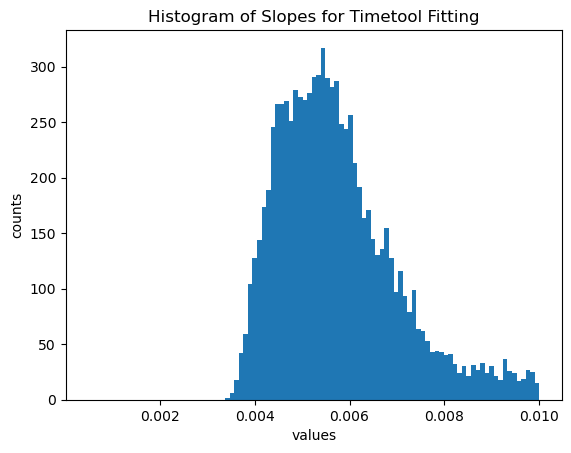

In [67]:
# bins = 1000
plt.figure()
hist, bins, _ = plt.hist(slopes, bins=np.linspace(0.0005, 0.01, 100)) #bin range followed by bin number
plt.title("Histogram of Slopes for Timetool Fitting")
plt.xlabel("values")
plt.ylabel("counts")
plt.show()

In [68]:
mins = []
maxs = []
bad = []
good = []
slope_min = 0.0038 #set values based on above histogram
slope_max = 0.007


print("# of bad fits: ", np.sum(hist[bins[0:-1] < slope_min]))
print("# of good fits: ", np.sum(hist[bins[0:-1] > slope_min]))

mins.append(min_val)
maxs.append(max_val)
bad.append(np.sum(hist[bins[0:-1] < slope_min]))
good.append(np.sum(hist[bins[0:-1] > slope_min])) #Sums the total number of counts across all bins of good fits

# of bad fits:  127.0
# of good fits:  8431.0


0  :  0.0046564256345544034
1  :  0.0038271540287669326
2  :  0.005704121687929342
3  :  0.005413641999261775
4  :  0.005327750935084778


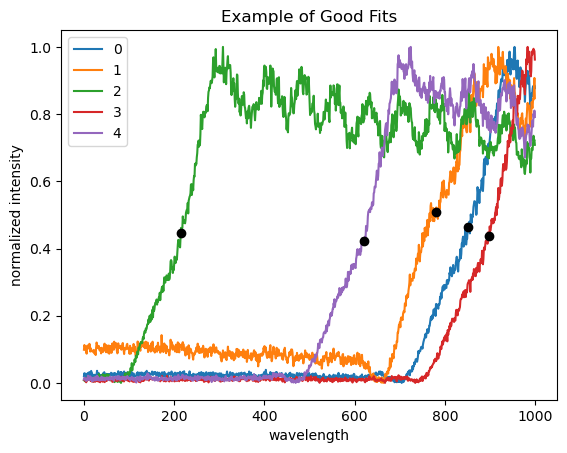

In [69]:
plt.figure()
i = 0
while i < 5:
    rand = np.random.randint(0,len(centers)) #randomly selects an index from the centers array
    if (slopes[rand] > slope_min) and (slopes[rand] < slope_max):
        print(i, " : ", slopes[rand])
        plt.plot(norm_all[rand], label = i)
        plt.plot(centers[rand], amps[rand], "ko")
        #plt.plot(tt_reference[rand], "--")
        i = i + 1
plt.title("Example of Good Fits")
plt.xlabel("wavelength")
plt.ylabel("normalized intensity")
plt.legend()
plt.show()

In [70]:
good_range = (slopes > slope_min) & (slopes < slope_max) #These threshold values are defined above (2 cells up)
centers_good = centers[good_range] #Sets the good range for each variable based off the restriction set one line above
amps_good = amps[good_range]
good_raw = ttRaw[good_range]
#dg2_good = dg2[good_range]
#print(amps_good)
norm_good = norm_all[good_range]
slopes_good = slopes[good_range]
scan_good = scan[good_range]
#qadc1_peaks = np.sum(qadc1[:, 4900:5300], axis=1)
#qadc1_good = qadc1_peaks[good_range]
print(sum(good_range))

7187


[1.0162445695147757e-12, -1.5873209199652406e-15]


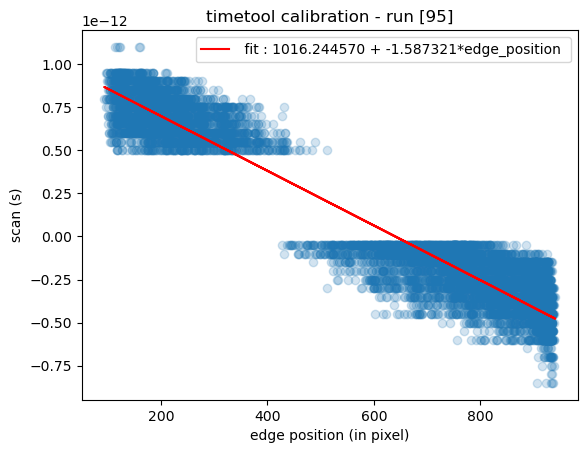

In [71]:
ft = np.polyfit(centers_good,scan_good,1)

#c = ft[0] 
b=ft[0] #contains slope from fit
a = ft[1] #contains intercept from fit

print([a,b])

z = np.polyval(ft,(centers_good))
y = a + b*centers_good # +  c*edge_position_tt[Idx_final]*edge_position_tt[Idx_final]
clean_a = a*1e15 #converts to seconds
clean_b = b*1e15
plt.figure()
plt.scatter(centers_good, scan_good,alpha=0.2)
plt.plot(centers_good,y,color = 'red', label=' fit : {:4f} + {:4f}*edge_position '.format(clean_a, clean_b))
plt.title('timetool calibration - run {}'.format(runNumbers))
plt.xlabel('edge position (in pixel)')
plt.ylabel('scan (s)')
plt.legend()
plt.show()

### Fourth: Return Statistics of Fit

In [72]:
correlation_matrix = np.corrcoef(centers_good, scan_good)#returns a 2x2 matrix where the diagonal elements correspond to the correlation of each array with itself (1)
#and the off diagonal elements correspond to the correlation between the centers_good and scan_good arrays. 
correlation_xy = correlation_matrix[0,1] #Extracts the correlation coefficient from the off diagonal element
r_squared_a = correlation_xy**2 #Squares it to get the R^2 value

print(r_squared_a)


0.913765413386926


Distribution of centers based on scan position. Looking for unimodal distributions. Somewhat spikey. Width is due to jitter of xray which follows a very normal distribution. 

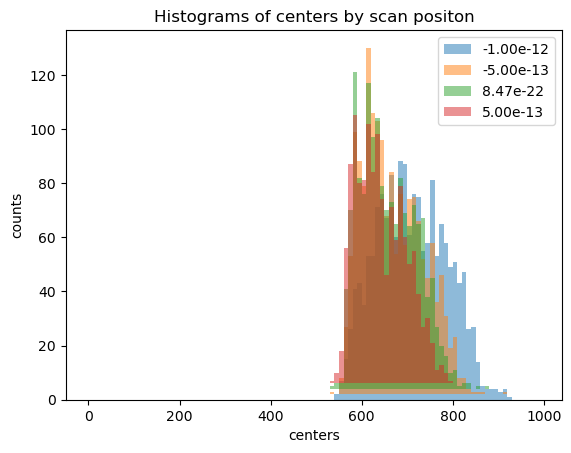

In [22]:
uni_scan = np.unique(scan_good) #Finds all unique values in the array and stores them in uni_scan

plt.figure()
for i,s in enumerate(uni_scan[::5]): #Take every 5th element
    plt.hist(centers_good[scan_good==s], bins=np.arange(0, 1000, 10), alpha=0.5,bottom=2*i, label=f'{s:.2e}')
#s is the scan value from uni_scan. Plots centers to only those entries where scan good equals the value s
#bottom variable sets the offset of the multiple histograms
plt.title("Histograms of centers by scan positon")
plt.legend()
plt.xlabel("centers")
plt.ylabel("counts")
plt.show()



## Timetool Results from Preprocessing 

Can't remember why I was using this section and it looks buggy right now so just ignore?

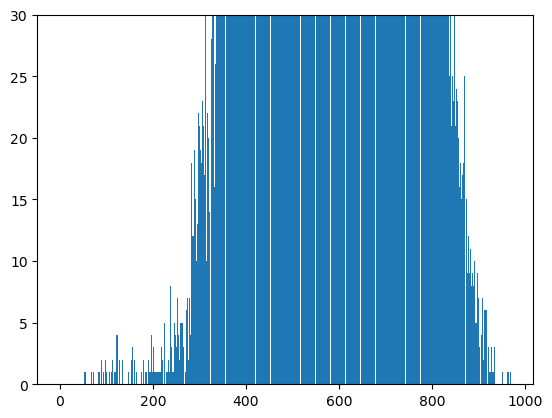

In [47]:
bins = 1000
plt.figure()
plt.hist(ttRefit_edges, bins=bins)
#plt.xlim(10, 800)
plt.ylim(0, 30)
plt.show()

0  :  0.0052401820899578766
1  :  0.005426589286905477
2  :  0.00549355866134246
3  :  0.005941243110449206
4  :  0.005607012314134639


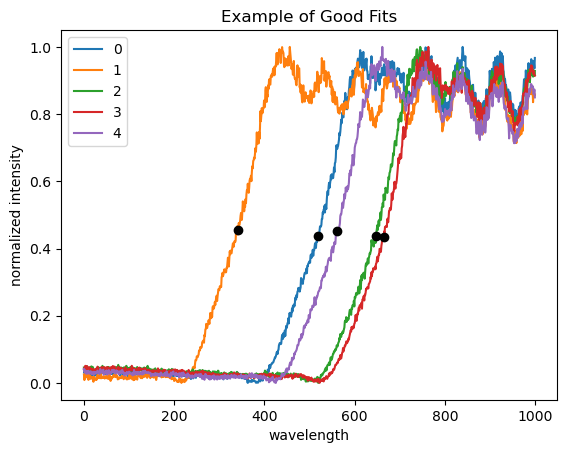

5


In [48]:
plt.figure()
i = 0
count=0
while i < 5:
    rand = np.random.randint(0,len(ttRefit_edges))
    if (ttRefit_slopes[rand] > 0.005) and (ttRefit_slopes[rand] < 0.01):
        print(i, " : ", ttRefit_slopes[rand])
        plt.plot(ttRefit_data[rand], label = i)
        plt.plot(ttRefit_edges[rand], ttRefit_amp[rand], "ko")
        i = i + 1
plt.title("Example of Good Fits")
plt.xlabel("wavelength")
plt.ylabel("normalized intensity")
plt.legend()
plt.show()
count=count+1
print(count*5)

31352  :  0.004930192119106432
84813  :  0.0047655453618756375
152399  :  0.004728018881751515
106301  :  0.004967498595618329
109111  :  0.004881455960948352


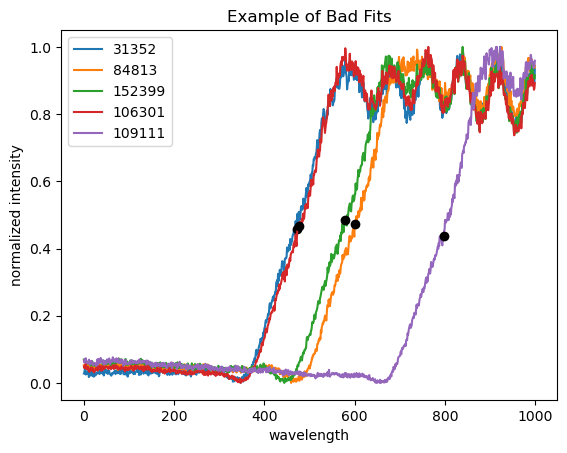

In [49]:
plt.figure()
i = 0
while i < 5:
    rand = np.random.randint(0,len(ttRefit_edges))
    if (ttRefit_slopes[rand] > 0.001) and (ttRefit_slopes[rand] < 0.005):
        print(rand, " : ", ttRefit_slopes[rand])
        plt.plot(ttRefit_data[rand], label = rand)
        plt.plot(ttRefit_edges[rand], ttRefit_amp[rand], "ko")
        i = i + 1
plt.title("Example of Bad Fits")
plt.xlabel("wavelength")
plt.ylabel("normalized intensity")
plt.legend()
plt.show()

### View Failed Fits

In [ ]:
# plt.figure()
# i = 0
# while i < 5:
#     rand = np.random.randint(0,len(centers))
#     if (slopes[rand] > 0.001) and (slopes[rand] < 0.003):
#         print(i, " : ", slopes[rand])
#         plt.plot(norm_all[rand], label = i)
#         plt.plot(centers[rand], amps[rand], "ko")
#         i = i + 1
# plt.title("Example of Bad Fits")
# plt.xlabel("wavelength")
# plt.ylabel("normalized intensity")
# plt.legend()
# plt.show()

### Select only good fits

In [142]:
good_range = (slopes > slope_min) & (slopes < slope_max)
centers_good = centers[good_range]
amps_good = amps[good_range]
norm_good = norm_all[good_range]
slopes_good = slopes[good_range]
scan_good = scan[good_range]
print(len(good_range))

7376


### Third: Get Linear Fit of Centers vs Stage Position

[1.109139659446938e-12, -1.5972431081120635e-15]


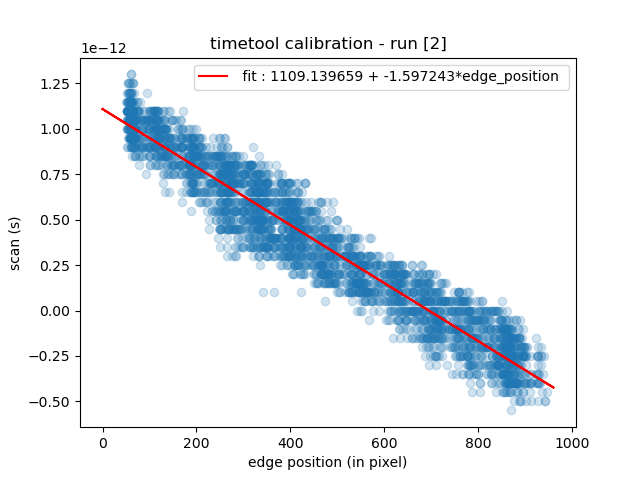

In [143]:
ft = np.polyfit(centers_good,scan_good,1)

#c = ft[0]
b=ft[0]
a = ft[1]

print([a,b])

z = np.polyval(ft,(centers_good))
y = a + b*centers # +  c*edge_position_tt[Idx_final]*edge_position_tt[Idx_final]
clean_a = a*1e15 # converting to fs
clean_b = b*1e15 # converting to fs
plt.figure()
plt.scatter(centers_good, scan_good,alpha=0.2)
plt.plot(centers,y,color = 'red', label=' fit : {:4f} + {:4f}*edge_position '.format(clean_a, clean_b))
plt.title('timetool calibration - run {}'.format(runNumbers))
plt.xlabel('edge position (in pixel)')
plt.ylabel('scan (s)')
plt.legend()
plt.show()

### Fourth: Return Statistics of Fit

In [112]:
correlation_matrix = np.corrcoef(centers_good, scan_good)
correlation_xy = correlation_matrix[0,1]
r_squared_a = correlation_xy**2

print(r_squared_a)


0.716439038138876


Distribution of centers based on scan position. Looking for unimodal distributions. Somewhat spikey. Width is due to jitter of xray which follows a very normal distribution. 

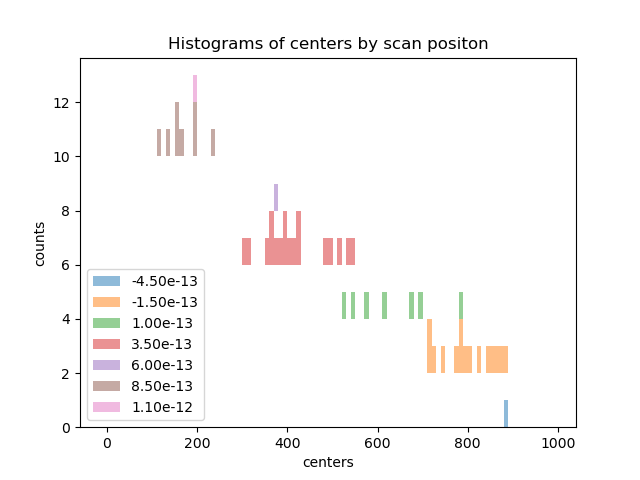

In [90]:
uni_scan = np.unique(scan_good)

plt.figure()
for i,s in enumerate(uni_scan[::5]): 
    plt.hist(centers_good[scan_good==s], bins=np.arange(0, 1000, 10), alpha=0.5,bottom=2*i, label=f'{s:.2e}')

plt.title("Histograms of centers by scan positon")
plt.legend()
plt.xlabel("centers")
plt.ylabel("counts")
plt.show()



### Testing Reference signal

In [154]:
tt_delta = tt_signal- tt_reference

0 15123
1 26230
2 749
3 638
4 23591


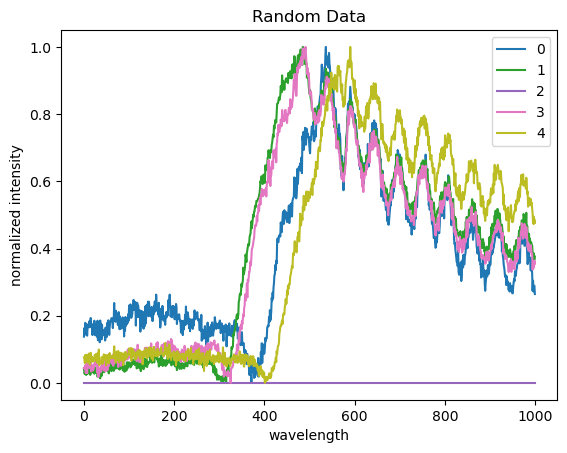

In [309]:
plt.figure()
i = 0
for i in range(0, 5):
    rand = np.random.randint(0,len(ttRefit_data))
    plt.plot(ttRefit_data[rand], label=i)
    plt.plot( ttRefit_edges[rand],ttRefit_amp[rand])
    print(i, rand)
    
plt.title("Random Data")
plt.xlabel("wavelength")
plt.ylabel("normalized intensity")
plt.legend()
plt.show()

## Plotting Histograms of Timetool Results

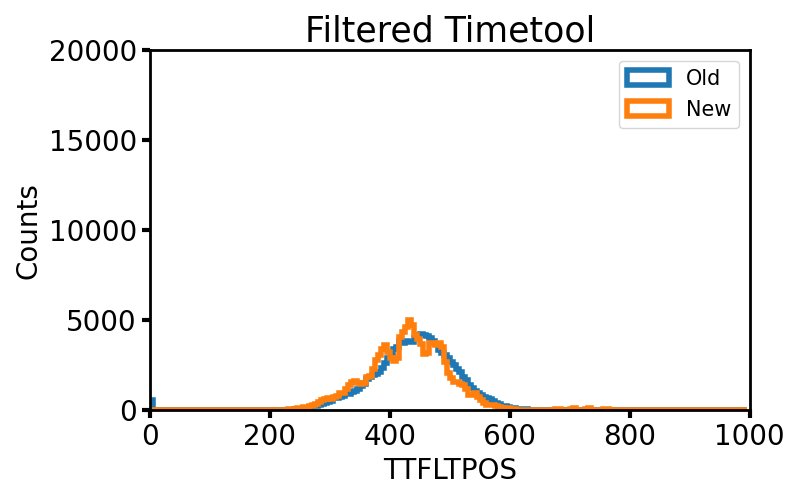

In [76]:
# plt.figure(figsize=(8,5))
# _,bins,_ = plt.hist(edge_locations,bins=np.linspace(100,1000,200))
# # plt.xlim(200,800)
# # plt.ylim(0,1200)
# plt.xlabel('TTFLTPOS')
# plt.ylabel('Counts')
# plt.title('Timetool')
# neaten_plot(plt.gcf())

# ttposIdx = (edge_locations>100) & (edge_locations<1000)
ttposIdx = (ttpos>100) & (ttpos<1000)
ttposIdx = ttposIdx & ~np.isnan(ttpos)
plt.figure(figsize=(8,5))
# plt.hist(edge_locations[ttposIdx],bins=bins)
plt.hist(ttpos_old[ttposIdx],bins=np.arange(0,1000,5),label='Old',histtype='step',lw=4)
plt.hist(ttpos[ttposIdx],bins=np.arange(0,1000,5),label='New',histtype='step',lw=4)
plt.xlim(0,1000)
plt.ylim(0,20000)
plt.xlabel('TTFLTPOS')
plt.ylabel('Counts')
plt.title('Filtered Timetool')
plt.legend(fontsize=15)
neaten_plot(plt.gcf())

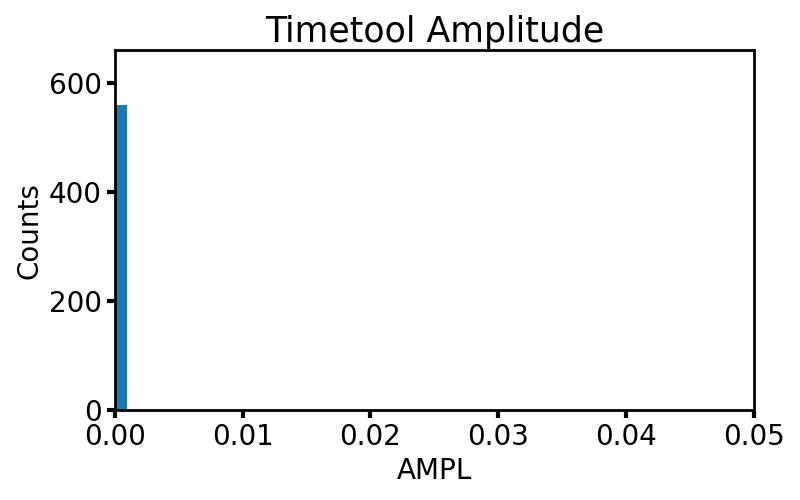

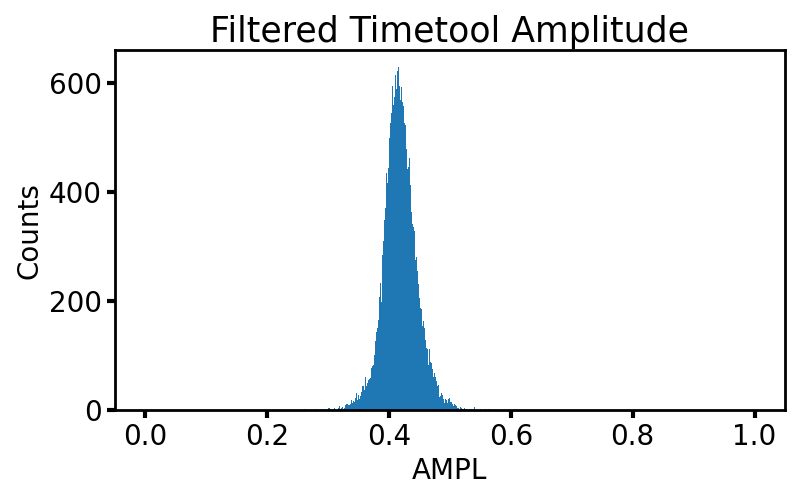

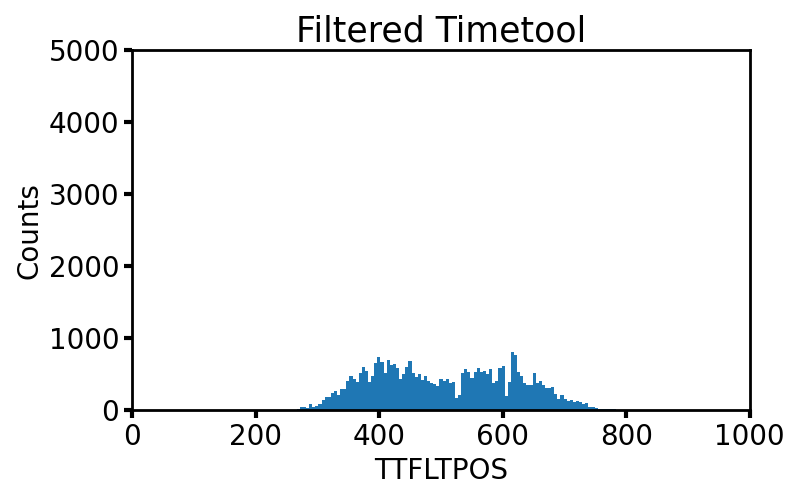

In [115]:
plt.figure(figsize=(8,5))
_,bins,_ = plt.hist(ttampl,bins=np.linspace(0,1,1000))
plt.xlim(0,0.05)
# plt.ylim(0,1200)
plt.xlabel('AMPL')
plt.ylabel('Counts')
plt.title('Timetool Amplitude')
neaten_plot(plt.gcf())

ttamplIdx = (ttampl>0.1)&(ttampl>0)
plt.figure(figsize=(8,5))
plt.hist(ttampl[ttamplIdx],bins=bins)
# plt.xlim(0,0.25)
# plt.ylim(0,1200)
plt.xlabel('AMPL')
plt.ylabel('Counts')
plt.title('Filtered Timetool Amplitude')
neaten_plot(plt.gcf())

plt.figure(figsize=(8,5))
plt.hist(ttpos[ttamplIdx],bins=np.linspace(0,1000,200))
plt.xlim(0,1000)
plt.ylim(0,5000)
plt.xlabel('TTFLTPOS')
plt.ylabel('Counts')
plt.title('Filtered Timetool')
neaten_plot(plt.gcf())

## Histogram time delay points (with timetool filter)

/tmp/ipykernel_3624474/1291568400.py:11: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(8,5))


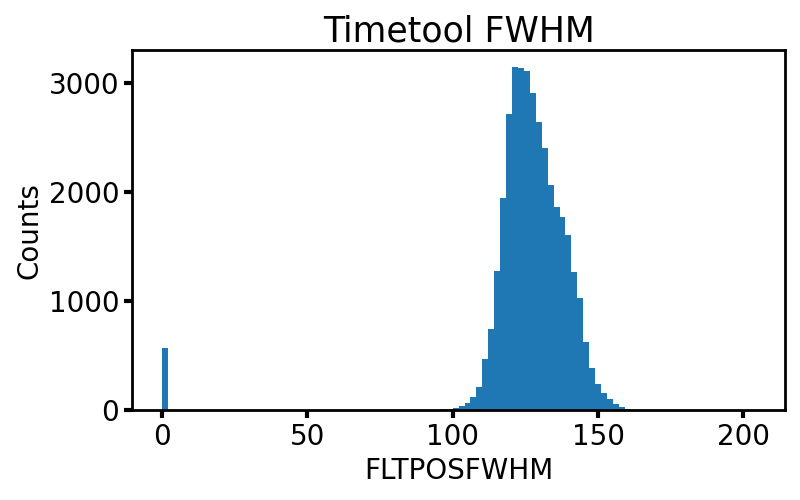

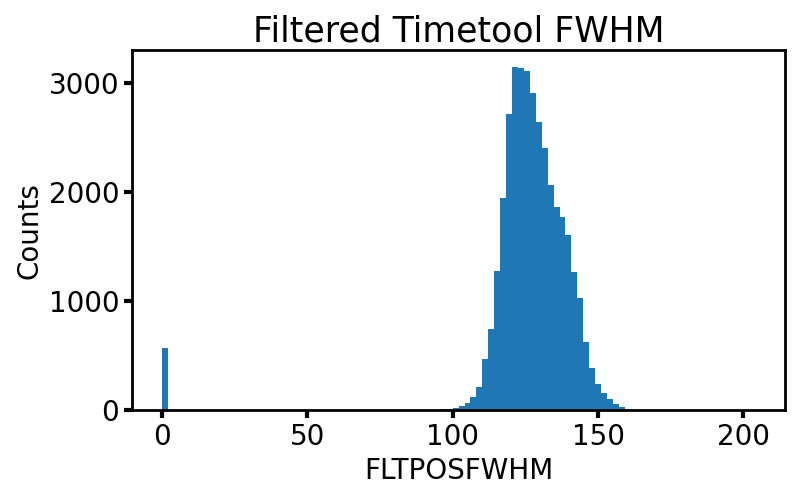

In [116]:
plt.figure(figsize=(8,5))
_,bins,_ = plt.hist(ttfwhm,bins=100)
# plt.xlim(0,2000)
# plt.ylim(0,2000)
plt.xlabel('FLTPOSFWHM')
plt.ylabel('Counts')
plt.title('Timetool FWHM')
neaten_plot(plt.gcf())

ttfwhmIdx = (ttfwhm<50e7)
plt.figure(figsize=(8,5))
plt.hist(ttfwhm[ttfwhmIdx],bins=bins)
# plt.xlim(0,2000)
# plt.ylim(0,2000)
plt.xlabel('FLTPOSFWHM')
plt.ylabel('Counts')
plt.title('Filtered Timetool FWHM')
neaten_plot(plt.gcf())

36223


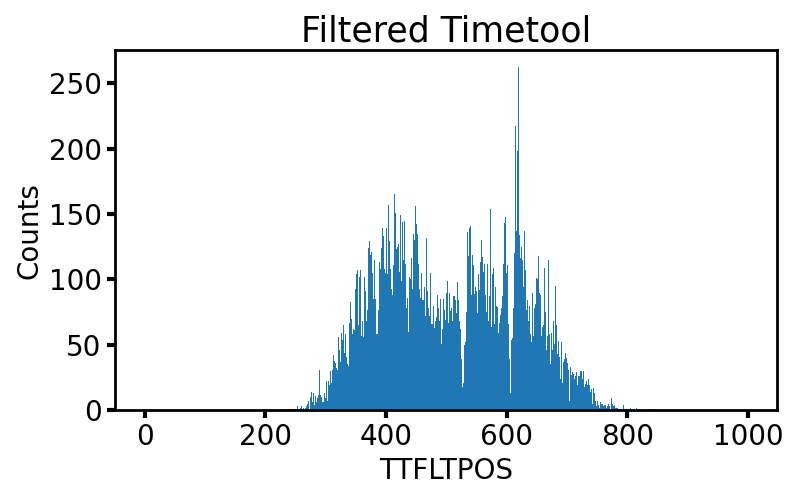

In [117]:
ttIdx = ttposIdx# & ttamplIdx & ttfwhmIdx
print(np.sum(ttIdx))
plt.figure(figsize=(8,5))
# plt.hist(edge_locations[ttIdx],bins=np.linspace(0,1000,100))
plt.hist(ttpos[ttposIdx],bins=np.arange(1000))
# plt.xlim(200,800)
# plt.ylim(0,1200)
plt.xlabel('TTFLTPOS')
plt.ylabel('Counts')
plt.title('Filtered Timetool')
neaten_plot(plt.gcf())

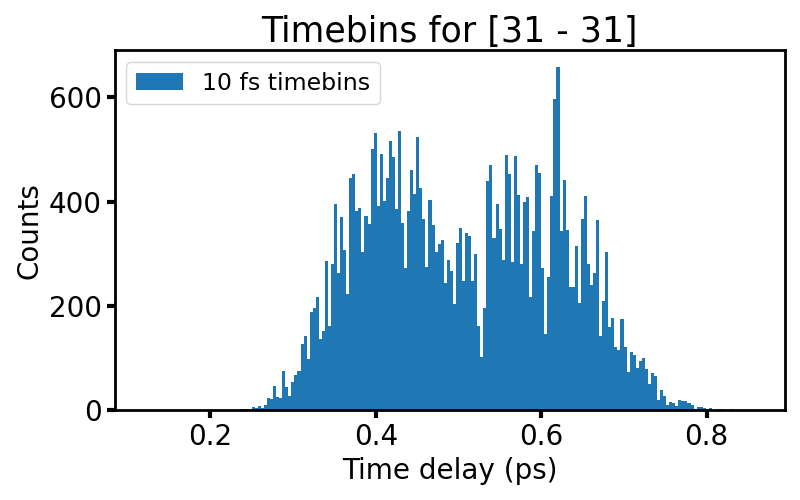

In [118]:
ttpoly = [2.95684259e-06, -1.43969413e-03] # polynomial fit parameters for timetool calibration (pixels --> fs)


fwhm = 150
pixels_to_ps = 1e-3*150/fwhm
scan_ttcorr = scan + ttpos*pixels_to_ps
timebin_size = 10
bins = np.arange(-2,2,timebin_size*1e-3)

plt.figure(figsize=(8,5))
plt.hist(scan_ttcorr[ttIdx],bins=200,label=f'{timebin_size} fs timebins')
plt.title('Timebins for '+runNumbersRange)
plt.xlabel('Time delay (ps)')
plt.ylabel('Counts')
plt.legend(fontsize=17)
# plt.xlim(-0.5,4)
neaten_plot(plt.gcf())

## QADC Analysis

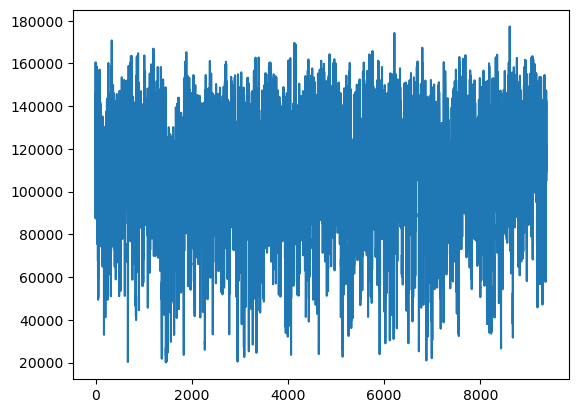

In [46]:
good_idx = np.where(dg2 > 20000)[0]

dg2 = dg2[good_idx]

qadc1 = qadc1[good_idx, :]

scan = scan[good_idx]
# scan0 = scan0[good_idx]
#ttampl = ttampl_IG[good_idx]
#ttampl = amps_good[good_idx]
# ttfwhm = ttfwhm[good_idx]
# ttdata = ttRaw[good_idx, :]

plt.figure()
plt.plot(dg2)
plt.show()

In [47]:
# baseline = np.mean(dg2)

# correction_factor = (dg2/baseline)
#print(correction_factor)
qadc_min = 4900
qadc_max = 5500
#Normalize qadc1 data based on above correction factor
qadc1_peaks = np.sum(qadc1[:, qadc_min:qadc_max], axis=1)
#adj_qadc1 = qadc1_peaks/(1 + correction_factor)
# tt_sums = np.sum(ttRaw, axis=1)
# print(tt_sums.shape)
    
# adj_qadc1 = np.array(adj_qadc1)
#print(adj_qadc1.shape)

# tt_sums = []

# for i in range(len(centers_good)):
#     temp = np.sum(good_raw[i, centers_good[i]:], axis=0)
#     tt_sums.append(temp)

# tt_sums = np.array(tt_sums)
# print(tt_sums.shape)

In [48]:
centers_good.shape

(3155,)

(9375,)


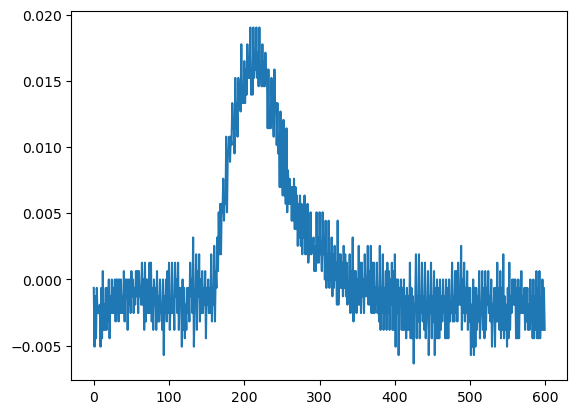

In [53]:
UV_sum = qadc1_peaks
print(UV_sum.shape)

plt.figure()
plt.plot(qadc1[100][qadc_min:qadc_max])
plt.show()

In [50]:
norm_good.shape

(3155, 1000)

9375 79


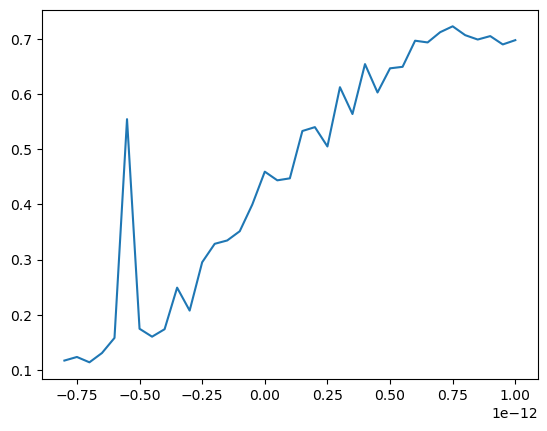

In [54]:
# scan = scan0
scan = scan
print(len(scan), len(np.unique(scan)))
uni_pos = np.unique(scan)
UV_sums = []
UV_std = []
UV_means = []
tt_total = []
tt_std = []

# group based on scan position:
for pos in uni_pos:
    sum_temp = UV_sum[np.where(scan == pos)[0]]
    mean_temp = UV_sum[np.where(scan == pos)[0]]
    UV_sums.append(np.nanmean(sum_temp, axis=0))
    UV_std.append(np.nanstd(sum_temp, axis=0))
    UV_means.append(np.nanmean(mean_temp, axis=0))
    # tt_temp = tt_sums[np.where(scan==pos)[0]]
    # tt_total.append(np.nanmean(tt_sums, axis=0))
    
    
# idx_sort = np.argsort(uni_pos)
# print(idx_sort)
# uni_pos = np.array(uni_pos[idx_sort])
# UV_sums = np.array(UV_sums[idx_sort])
# UV_means = np.array(UV_means[idx_sort])
tt_scan = scan_good
uni_scan = np.unique(tt_scan)
for pos in uni_scan:
    idx = np.where(tt_scan == pos)[0]
    tt_temp = norm_good[idx, :]
    tt_total.append(np.nanmean(tt_temp))

tt_total = np.array(tt_total)
plt.figure()
plt.plot(uni_scan, tt_total)
plt.show()

/lscratch/lheald2/tmp/ipykernel_2715527/1521797423.py:21: OptimizeWarning: Covariance of the parameters could not be estimated
  popt_exp, pcov_exp = curve_fit(erf_new, t_exp, y_exp, p0=p0)


Optimized parameters: 
 a = 0.0352 
 sigma = 0.001423 
 FWHM = 0.001675       
 t0 = -0.67 
 offset = 0.78


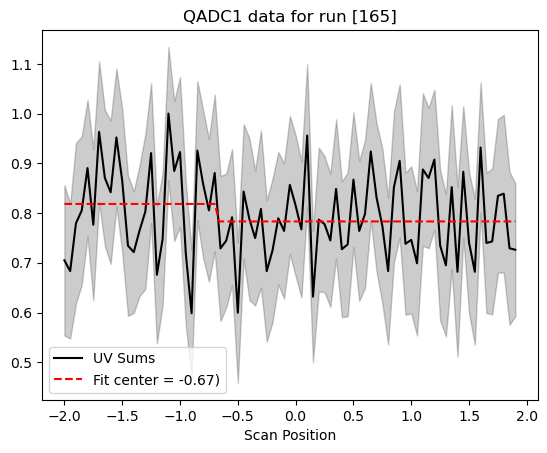

Optimized parameters: 
 a = -0.5848 
 sigma = 0.844353 
 FWHM = 0.993803       
 t0 = 0.01 
 offset = 0.72


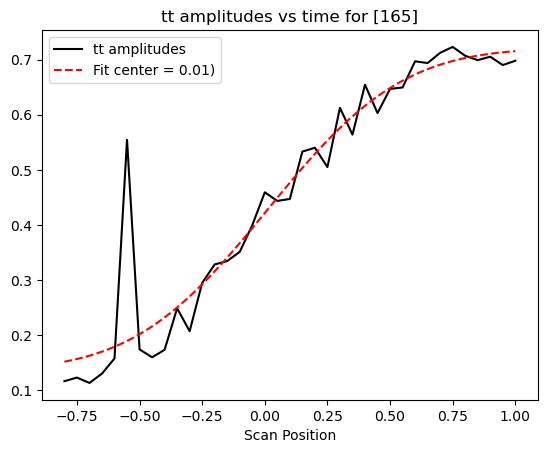

In [55]:
from scipy.optimize import curve_fit
from scipy.special import erf, erfc


def erf_function(t, a, sigma, c, b):
    fit = a* (1-erf(-(t-c)/(sigma))) + b
    return fit

def erf_new(x_data, offset, sigma, center, constant):
    fit = (offset/2)*erfc((x_data-center)*np.sqrt(2)/sigma)+constant
    return fit

# Initial guesses for the fit parameters
p0 = [0.4, 0.5, 0.0, 1] # a, sigma, tau, c
#bounds = ([-1, 0, 0, -0.01], [0.5, 1, 300, 0])
t_exp = uni_pos*1e12
#print(np.abs(uni_pos))
y_exp = UV_sums/np.max(UV_sums)
y_std = UV_std/np.max(UV_sums)
# Fit the data using curve_fit
popt_exp, pcov_exp = curve_fit(erf_new, t_exp, y_exp, p0=p0)

# Print the optimized parameters
print(f"Optimized parameters: \n a = {popt_exp[0]:.4f} \n sigma = {popt_exp[1]:.6f} \n FWHM = {1.177*popt_exp[1]:.6f} \
      \n t0 = {popt_exp[2]:.2f} \n offset = {popt_exp[3]:.2f}")
x_new = np.linspace(np.min(t_exp), np.max(t_exp), 100)
fit_line =  erf_new(x_new, *popt_exp)

plt.figure()
plt.plot(t_exp, y_exp, color="k", label="UV Sums")
plt.fill_between(t_exp, y_exp-y_std, y_exp+y_std, color='k', alpha=0.2)
plt.plot(x_new, fit_line, "--", color='r', label=f"Fit center = {popt_exp[2]:.2f})")
plt.legend()
plt.xlabel("Scan Position")
plt.title(f"QADC1 data for run {str(runNumbers)}")
plt.show()

# Initial guesses for the fit parameters
p0 = [0.4, 0.5, 0.0, 1] # a, sigma, tau, c
#bounds = ([-1, 0, 0, -0.01], [0.5, 1, 300, 0])
t_exp = uni_scan*1e12
#t_exp = t_exp[np.where(t_exp < 1)[0]]
#print(np.abs(uni_pos))
y_exp = tt_total
# y_std = np.array(tt_std)[np.where(t_exp < 1)[0]]
# Fit the data using curve_fit
popt_exp, pcov_exp = curve_fit(erf_new, t_exp, y_exp,p0=p0)

# Print the optimized parameters
print(f"Optimized parameters: \n a = {popt_exp[0]:.4f} \n sigma = {popt_exp[1]:.6f} \n FWHM = {1.177*popt_exp[1]:.6f} \
      \n t0 = {popt_exp[2]:.2f} \n offset = {popt_exp[3]:.2f}")
x_new = np.linspace(np.min(t_exp), np.max(t_exp), 100)
fit_line =  erf_new(x_new, *popt_exp)

plt.figure()
plt.plot(t_exp, y_exp, color="k", label="tt amplitudes")
#plt.fill_between(t_exp, y_exp-y_std, y_exp+y_std, color='k', alpha=0.2)
plt.plot(x_new, fit_line, "--", color='r', label=f"Fit center = {popt_exp[2]:.2f})")
plt.legend()
plt.xlabel("Scan Position")
plt.title(f"tt amplitudes vs time for {str(runNumbers)}")
plt.show()

## Playing with other fitting ideas

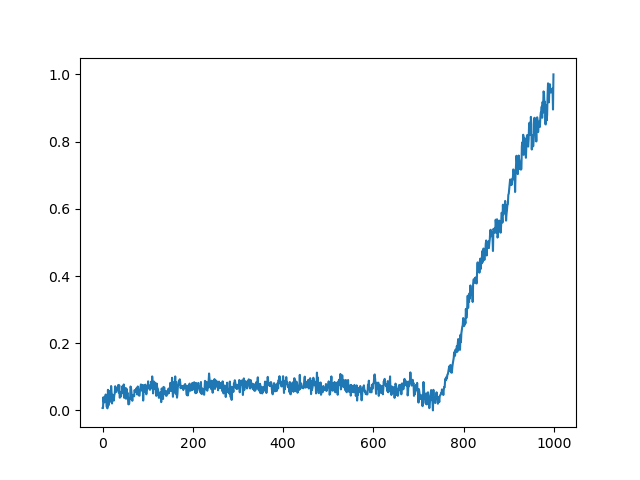

In [188]:
plt.figure()
plt.plot(norm_all[3050])
plt.show()

temp = norm_all[3050]

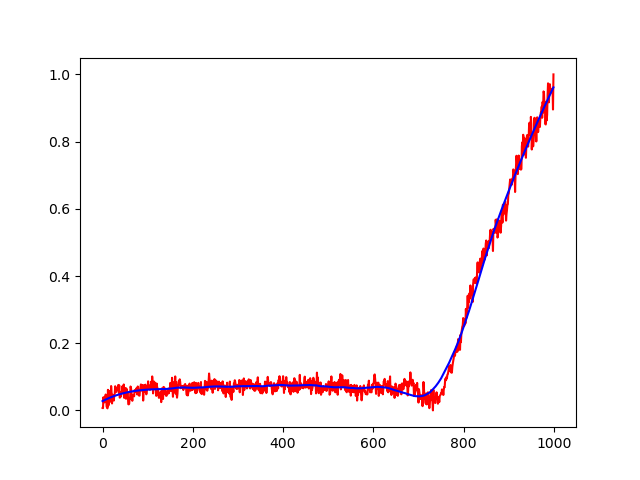

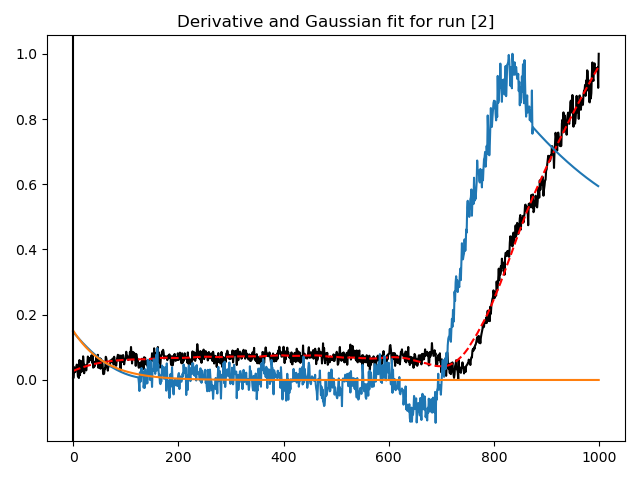

gaussian sigma = 293.18, FWHM = 690.43


In [189]:
from scipy.signal import savgol_filter

temp_filt = savgol_filter(temp, 251, 3)

plt.figure()
plt.plot(temp, color="red", label="original")
plt.plot(temp_filt, color='blue', label='filtered')
plt.show()

deriv = np.diff(temp_filt)

def gauss(x_data, offset, x_0, sigma):
    return offset*np.exp(-(x_data-x_0)**2/(2*sigma**2))

guesses = [0.02, 0, 3]

new_x = np.arange(0, len(temp))
popt, pcov = curve_fit(gauss, new_x[:-1], deriv)

fit = gauss(new_x, *popt)

plt.figure()
plt.plot(new_x, temp, color="k", label="original trace")
plt.plot(new_x, temp_filt, "--", color="red", label='smoothed trace')
plt.plot(new_x[:-1], deriv/np.max(deriv))
plt.plot(new_x, fit/np.max(deriv))
plt.axvline(np.argmax(fit), color='k')
plt.title(f"Derivative and Gaussian fit for run {runNumbers}")
plt.tight_layout()
plt.show()

print(f"gaussian sigma = {popt[2]:.2f}, FWHM = {popt[2]*2.355:.2f}")

In [193]:
start = time.time()

centers = []
amps = []
norm_all = []
scan_good = []
slopes = []
min_val = 0.2
max_val= 0.6
count = 0
for i in range(0, 500):
    try:
        temp = savgol_filter(ttRaw[i], 251, 3)
        deriv = np.diff(temp)
        norm_deriv = deriv/np.max(deriv)
        new_x = np.arange(0, len(temp))
        popt, pcov = curve_fit(gauss, new_x[:-1], deriv)
        fit = gauss(new_x, *popt)/np.max(deriv)
        if np.max(fit) < 0.5 * np.min(fit):
            count += 1
        else:
            slopes.append(popt[2])
            centers.append(np.argmax(fit))
            amps.append(np.max(fit))
            #print(norm_data.shape)
            norm_all.append(normalize(temp))
    except Exception as e:
        # Handle fitting errors and move to the next dataset
        print(f"Skipping dataset {i} due to error")
        continue

#print(norm_all)
centers = np.array(centers)
amps = np.array(amps)
norm_all = np.array(norm_all)
slopes = np.array(slopes)

print(len(slopes))
# print(len(amps))
# print(len(norm_all))

end = time.time()
print((end - start), "seconds")
print(len(centers))

Skipping dataset 0 due to error
Skipping dataset 1 due to error
Skipping dataset 3 due to error
Skipping dataset 4 due to error
Skipping dataset 5 due to error
Skipping dataset 6 due to error
Skipping dataset 8 due to error
Skipping dataset 9 due to error
Skipping dataset 10 due to error
Skipping dataset 11 due to error
Skipping dataset 12 due to error
Skipping dataset 13 due to error
Skipping dataset 14 due to error
Skipping dataset 16 due to error
Skipping dataset 17 due to error
Skipping dataset 18 due to error
Skipping dataset 19 due to error
Skipping dataset 20 due to error
Skipping dataset 21 due to error
Skipping dataset 23 due to error
Skipping dataset 24 due to error
Skipping dataset 25 due to error
Skipping dataset 26 due to error
Skipping dataset 27 due to error
Skipping dataset 29 due to error
Skipping dataset 30 due to error
Skipping dataset 31 due to error
Skipping dataset 33 due to error
Skipping dataset 37 due to error
Skipping dataset 38 due to error
Skipping dataset 3

[1.0551715359122425e-12, -1.5427985568417887e-15]


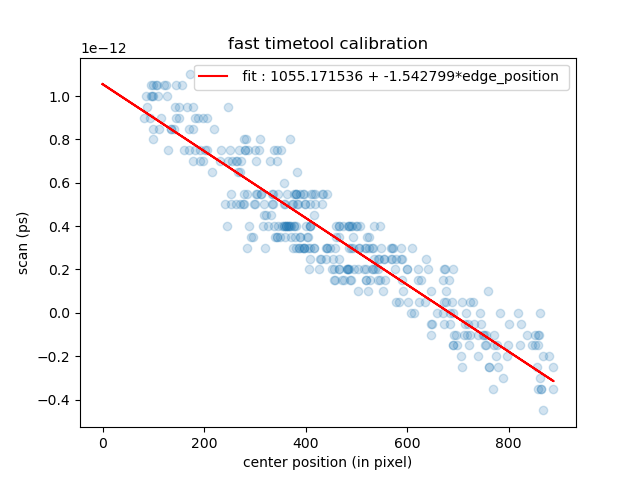

In [138]:
ft = np.polyfit(centers_good,scan_good,1)

c = ft[0]
b=ft[0]
a = ft[1]

print([a,b])

z = np.polyval(ft,(centers_good))
y = a + b*centers # +  c*edge_position_tt[Idx_final]*edge_position_tt[Idx_final]
clean_a = a*1e15
clean_b = b*1e15
plt.figure()
plt.scatter(centers_good, scan_good,alpha=0.2)
plt.plot(centers,y,color = 'red', label=' fit : {:4f} + {:4f}*edge_position '.format(clean_a, clean_b))
plt.title('fast timetool calibration')
plt.xlabel('center position (in pixel)')
plt.ylabel('scan (ps)')
plt.legend()
plt.show()

In [139]:
correlation_matrix = np.corrcoef(centers_good, scan_good)
correlation_xy = correlation_matrix[0,1]
r_squared_a = correlation_xy**2

print(r_squared_a)


0.8764969842172966


In [140]:
x = np.arange(0, 1000)
by = 1.379749596205207e-12 + -1.9481342259572973e-15*x
ly = a+ b*x